In [1]:
import pandas as pd
import numpy as np
import sklearn

import os
import gc

import matplotlib.pyplot as plt

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive')

  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'AI Dataset Sample/'

  !pip install fastai pydicom kornia --upgrade --quiet
  
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

  IN_COLAB = True
except:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'
  IN_COLAB = False

import pydicom

from fastai.basics import *
from fastai.medical.imaging import *

In [3]:
PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'raw'
organize_folder = PATH_PREFIX + 'organized'
preprocess_folder = PATH_PREFIX + 'preprocess'

In [59]:
from utils import organize_folders, generate_template, rename_patient

groups = ['LS', 'CD', 'IF']
subgroup_length = 2

organize_folders(raw_folder, organize_folder, groups=groups, subgroup_length=subgroup_length, force_extension='.dcm', debug=False)

dicom_files = get_files(organize_folder, extensions='.dcm')
rename_patient(dicom_files)

generate_template(organize_folder, groups, subgroup_length, excel=True)

# Remove data from memory
# del(dicom_files)
# gc.collect();

,0,1,2,3,4,5,6,7,8,9
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED
SOPClassUID,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1
SOPInstanceUID,1216.1158.1243.113.1196.184.20190117113311.11,1216.1158.1243.113.1196.184.20190304113146.3,1216.1158.1243.113.1196.184.20190215174436.39,1216.1158.1243.113.1196.184.20190220113109.3,1216.1158.1243.113.1196.184.20190129103613.3,1216.1158.1243.113.1196.184.20190314154700.11,1216.1158.1243.113.1196.184.20190326143920.13,1216.1158.1243.113.1196.184.20190130113155.3,1216.1158.1243.113.1196.184.20190226200138.31,1216.1158.1243.113.1196.184.20190305135429.11
StudyDate,20190117,20190304,20190215,20190220,20190129,20190314,20190326,20190130,20190226,20190305
...,...,...,...,...,...,...,...,...,...,...
img_min,88,141,136,143,88,82,108,124,129,204
img_max,4051,4002,4039,4074,4046,4054,4044,4047,4034,4028
img_mean,1313.57,1412.97,1524.69,1383.55,1333.04,1427.68,1445.9,1209.44,1575.75,1136.37
img_std,925.985,869.146,959.375,947.756,969.833,966.333,959.274,905.58,956.061,826.035


1 frame per file
1 frame per file


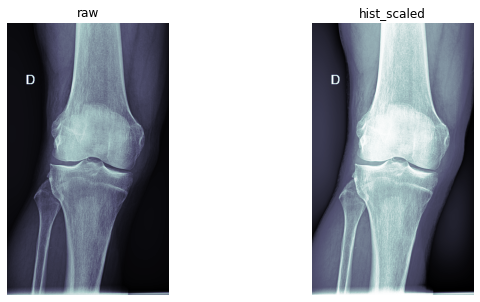

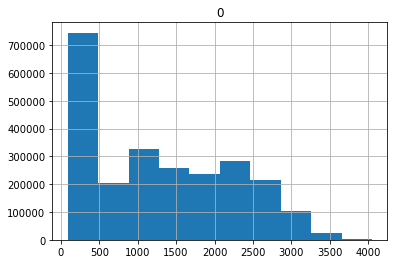

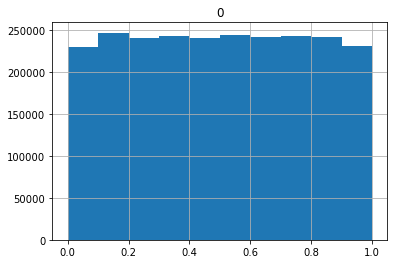

In [50]:
dcms = get_files(organize_folder, extensions='.dcm')[:10].map(dcmread)
dcm = dcms[0]
scales = False, True
titles = 'raw','hist_scaled'
for s,a,t in zip(scales, subplots(1,2,imsize=5)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t);
pd.DataFrame(dcm.pixel_array.reshape(-1)).hist();
pd.DataFrame(dcm.hist_scaled().reshape(-1)).hist();

In [53]:
from preprocessing import DCMPreprocessDataset

n_samples = 10 # None

fnames = get_files(organize_folder, extensions='.dcm')

dataset = DCMPreprocessDataset(fnames=fnames, padding_to_square=True, resize=None)
bins = dataset.init_bins(n_samples=n_samples)
# dataset.bins = bins

dataset.save(preprocess_folder)

In [57]:
from utils import concat_templates

# df = concat_templates(organize_folder, excel=True)
# df.to_excel(
#     os.path.join(preprocess_folder, 'all.xls'),
#     index=False
# )

df = pd.read_excel(os.path.join(dst_folder, 'all.xls'), dtype={'ID':'string','Target':'string'})

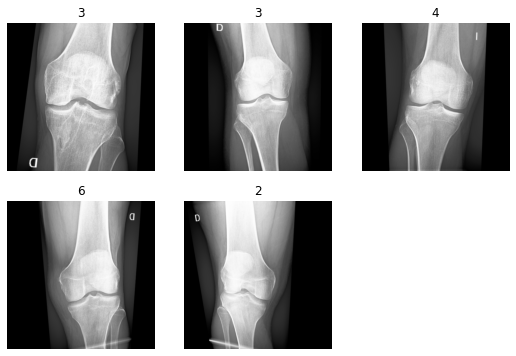

In [58]:
from fastai.data.block import *
from fastai.vision.data import *
from fastai.vision.augment import *
from fastai.data.transforms import *

dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=ColReader('ID', pref=preprocess_folder+'/', suff='.png'), 
    get_y=ColReader('Target'),
    splitter=RandomSplitter(),
    item_tfms=Resize(512),
    batch_tfms=[*aug_transforms()],
).dataloaders(df[['ID','Target']], bs=5)

dls.show_batch()